# Fraud detection dataset
Fraud detection dataset is an example dataset from kaggle.com analyzed for educational purposes. 

## Imports and settings

In [363]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.inspection import PartialDependenceDisplay
# Setting jupyter display settings, so that it doesn't hide any columns
pd.set_option('display.max_columns', None) 

## General overview of dataset

In [364]:
fraud = pd.read_csv('fraud_detection_bank_dataset.csv')
print(fraud.head())
print(fraud.shape)

   Unnamed: 0  col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8  \
0           0      9   1354      0     18      0      1      7      9      0   
1           1      0    239      0      1      0      1      0      0      0   
2           2      0    260      0      4      0      3      6      0      0   
3           3     17    682      0      1      0      0      8     17      0   
4           4      1    540      0      2      0      1      7      1      0   

   col_9  col_10  col_11  col_12  col_13  col_14  col_15  col_16  col_17  \
0      0       0       0       0       0       1       0       1       0   
1      0       0       0       0       0       0       0       1       0   
2      0       0       0       0       0       1       1       0       0   
3      0       0       0       0       0       0       0       1       0   
4      0       0       0       0       0       1       0       1       0   

   col_18  col_19  col_20  col_21  col_22  col_23  col_24  col

In [365]:
print(fraud.describe())

         Unnamed: 0         col_0         col_1         col_2         col_3  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean   10233.500000      3.226256    294.793043      0.420021      2.329343   
std     5908.746991     20.564308    717.541984      7.367275     10.068512   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     5116.750000      0.000000     38.000000      0.000000      0.000000   
50%    10233.500000      0.000000     97.000000      0.000000      1.000000   
75%    15350.250000      2.000000    283.000000      0.000000      2.000000   
max    20467.000000   2301.000000  37808.000000    904.000000    772.000000   

              col_4         col_5         col_6         col_7    col_8  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.0   
mean       0.083594      0.939857      2.386066      3.226256      0.0   
std        0.840537      4.222896      3.018140     20.564308     

Dataset has over 20K records and 114 columns. First column ("Unnamed: 0") is just record ID and is unnecessary for this analysis. Last column is our target value determining whether a transaction was a fraud (1) or not (0). Columns' names are not desriptive so it can be challenging to interpret feature importance and identify redundant features. Nevertheless we can still reduce dimentionality of this dataset. There are few columns that has always the same value (ex. 'col_8'). We can remove those columns because they do not provide any information for predicting target value. 

## Feature exploration

In [366]:
### Dropping Redundant Columns

In [367]:
fraud = fraud.drop('Unnamed: 0', axis=1)
fraud_no_zeros = fraud.loc[:, (fraud != 0).any(axis=0)]
print(fraud_no_zeros.describe())

              col_0         col_1         col_2         col_3         col_4  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean       3.226256    294.793043      0.420021      2.329343      0.083594   
std       20.564308    717.541984      7.367275     10.068512      0.840537   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000     38.000000      0.000000      0.000000      0.000000   
50%        0.000000     97.000000      0.000000      1.000000      0.000000   
75%        2.000000    283.000000      0.000000      2.000000      0.000000   
max     2301.000000  37808.000000    904.000000    772.000000     54.000000   

              col_5         col_6         col_7        col_13        col_14  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean       0.939857      2.386066      3.226256      0.038646      0.363152   
std        4.222896      3.018140     20.564308    

We reduced number of columns from 114 to 98. 

### Correlation

<Axes: >

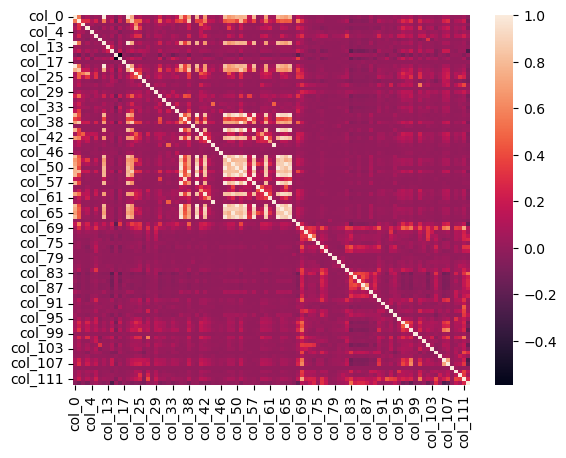

In [368]:
corr = fraud_no_zeros.corr()
sns.heatmap(corr)

There are many columns that are highly correlated and they will not bring much value to the prediction. Let's keep only the one that is mostly correlated to target value.

In [369]:
cols_to_drop = corr[corr['col_0']>0.7].index.values
print("Column highly correlated: ")
print(cols_to_drop)

col_most_corr_to_target = corr.loc['targets',cols_to_drop].sort_values().index[0]
print("Column most correlated to target column from list of highly correlated columns: " + col_most_corr_to_target)
cols_to_drop = np.delete(cols_to_drop, np.where(cols_to_drop == col_most_corr_to_target))
fraud_reduced = fraud_no_zeros.drop(cols_to_drop ,axis=1)
print(fraud_reduced.shape)

Column highly correlated: 
['col_0' 'col_7' 'col_22' 'col_23' 'col_36' 'col_40' 'col_47' 'col_49'
 'col_50' 'col_54' 'col_55' 'col_57' 'col_63' 'col_64' 'col_66']
Column most correlated to target column from list of highly correlated columns: col_23
(20468, 84)


<Axes: >

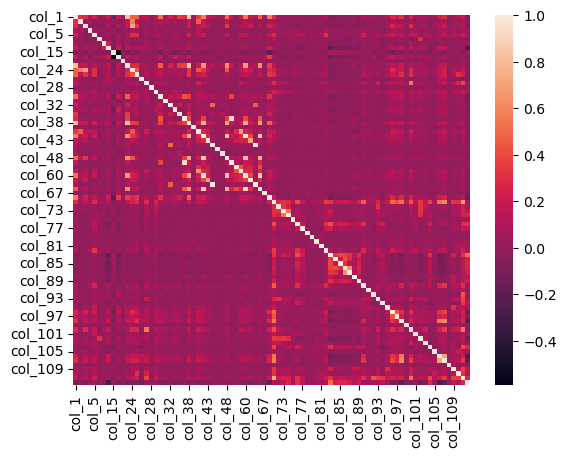

In [370]:
corr2 = fraud_reduced.corr()
sns.heatmap(corr2)

Checking for high correlation between features and target values
If we have in our dataset features highly correlated to target values then we can expect that our predictions will be very accurate and mostly based on this feature. It can also mean that creating a prediction model is unnecesary and one 'if' condition can solve our classification problem.

In [371]:
cols_with_high_corr_to_target = corr2[corr2['targets']>0.6].index.values
print(cols_with_high_corr_to_target)

['targets']


### Data types

In [372]:
print(fraud_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 84 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   col_1    20468 non-null  int64  
 1   col_2    20468 non-null  int64  
 2   col_3    20468 non-null  int64  
 3   col_4    20468 non-null  int64  
 4   col_5    20468 non-null  int64  
 5   col_6    20468 non-null  int64  
 6   col_13   20468 non-null  int64  
 7   col_14   20468 non-null  int64  
 8   col_15   20468 non-null  int64  
 9   col_16   20468 non-null  int64  
 10  col_17   20468 non-null  int64  
 11  col_23   20468 non-null  int64  
 12  col_24   20468 non-null  int64  
 13  col_25   20468 non-null  int64  
 14  col_26   20468 non-null  int64  
 15  col_27   20468 non-null  int64  
 16  col_28   20468 non-null  int64  
 17  col_29   20468 non-null  int64  
 18  col_30   20468 non-null  int64  
 19  col_31   20468 non-null  int64  
 20  col_32   20468 non-null  int64  
 21  col_33   204

In [373]:
binary = pd.DataFrame()
numerical = pd.DataFrame()
for col in fraud_reduced.columns:
    if fraud_reduced[col].min() == 0 and fraud_reduced[col].max() == 1:
        binary[col] = fraud_reduced[col]
    else: 
        numerical[col] = fraud_reduced[col]
        
print(binary.shape)
print(numerical.shape)

(20468, 42)
(20468, 42)


We have 42 binary columns and 42 numerical columns in our dataset. 

### Distribution and variance

In [374]:
print(numerical.describe())

              col_1         col_2         col_3         col_4         col_5  \
count  20468.000000  20468.000000  20468.000000  20468.000000  20468.000000   
mean     294.793043      0.420021      2.329343      0.083594      0.939857   
std      717.541984      7.367275     10.068512      0.840537      4.222896   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       38.000000      0.000000      0.000000      0.000000      0.000000   
50%       97.000000      0.000000      1.000000      0.000000      0.000000   
75%      283.000000      0.000000      2.000000      0.000000      1.000000   
max    37808.000000    904.000000    772.000000     54.000000    230.000000   

              col_6         col_17        col_23        col_24        col_25  \
count  20468.000000   20468.000000  20468.000000  20468.000000  20468.000000   
mean       2.386066     196.679500     34.201290      3.068790      2.701925   
std        3.018140    6700.095223    126.109375

Some features are almost entirely zeros. Let's check how many.

In [375]:
#sns.pairplot(numerical)
most_zeros = pd.DataFrame()
not_zeros = pd.DataFrame()
for col in numerical.columns:
    if np.percentile(numerical[col], 75)==0:
        most_zeros[col] = numerical[col]
    else:
        not_zeros[col] = numerical[col]
print(most_zeros.shape)
print(not_zeros.shape)

(20468, 27)
(20468, 15)


In [376]:
#sns.pairplot(not_zeros, corner = True) # WARNING - Calculates for few minutes
#plt.show()

We can see that in this dataset there are plenty outliers. Good practice would be to give them a closer look. Since there is not enough information about features, outliers will not be removed. They can contain some cruitial information and since it is not one or two values, but plenty, we can assume that it is correct feature distribution. 

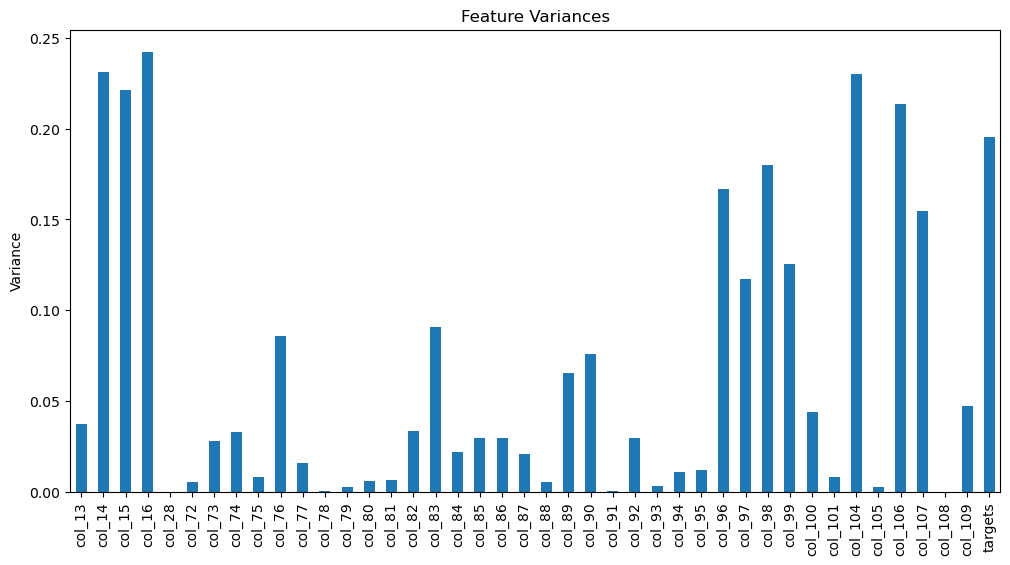

In [377]:
bin_variances = binary.var()
plt.figure(figsize=(12, 6))
bin_variances.plot(kind="bar")
plt.title("Feature Variances")
plt.ylabel("Variance")
plt.show()

For binary features variance is quite similar, except for few columns with very small variance. Let's check why.

In [378]:
fraud_reduced['col_28'].value_counts()

col_28
1    20467
0        1
Name: count, dtype: int64

Column 'col_28' has variance close to 0 because only one record has this feature. Since we do't know what it represents, let's keep it.

col_1      5.148665e+05
col_2      5.427674e+01
col_3      1.013749e+02
col_4      7.065017e-01
col_5      1.783285e+01
col_6      9.109166e+00
col_17     4.489128e+07
col_23     1.590357e+04
col_24     1.630340e+02
col_25     2.056505e+02
col_26     2.382040e+01
col_27     9.974635e-02
col_29     8.759652e+00
col_30     4.896366e+02
col_31     2.842702e+00
col_32     3.408692e+01
col_33     8.282123e-02
col_34     3.344500e+02
col_37     2.280191e+03
col_38     6.172543e+05
col_39     8.008688e-03
col_41     1.765910e+01
col_42     3.373495e+03
col_43     1.309650e+01
col_44     3.494698e+02
col_45     3.195069e+00
col_46     6.404742e-01
col_48     1.615166e+03
col_56     3.882225e+02
col_58     5.083056e-01
col_59     4.681646e+00
col_60     2.944617e+03
col_61     9.585286e+00
col_62     3.267348e+02
col_65     6.289294e+04
col_67     1.406312e+11
col_68     7.499842e+03
col_69     6.999202e+00
col_102    3.122711e-01
col_103    5.399014e-03
col_110    9.307333e-02
col_111    3.506

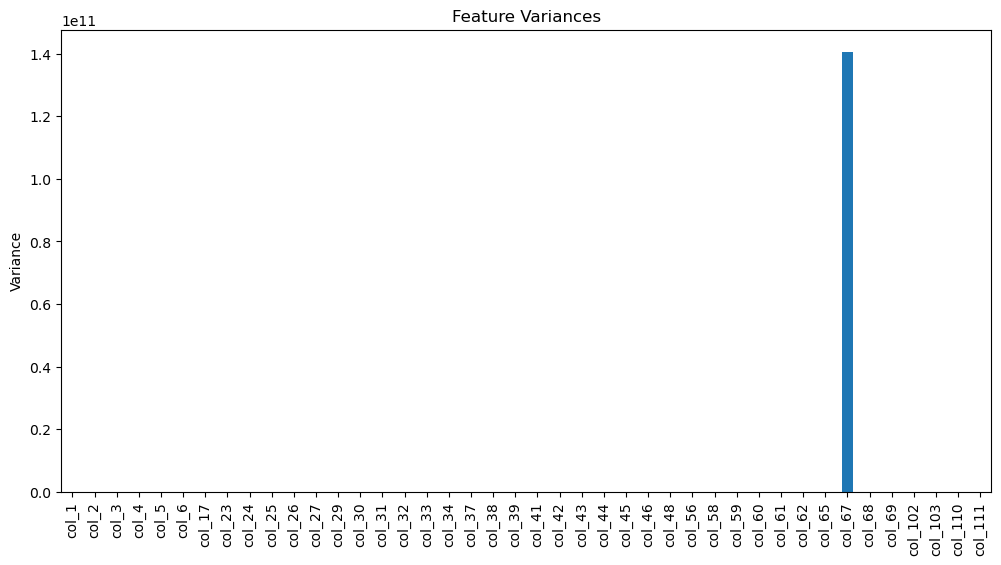

In [379]:
num_variances = numerical.var()
print(num_variances)
plt.figure(figsize=(12, 6))
num_variances.plot(kind="bar")
plt.title("Feature Variances")
plt.ylabel("Variance")
plt.show()

Numerical values have different variances. It is hard to visualize them on one plot, because some values are extremely large. Let's check if it is one outlier or more observations.

In [380]:
numerical['col_67'].value_counts()

col_67
0.000000         10491
209.000000           5
57.000000            4
407.000000           4
618.500000           3
                 ...  
547.555556           1
203216.285714        1
149457.906977        1
32323.487952         1
1163.329545          1
Name: count, Length: 9743, dtype: int64

Column 'col_67' has multiple large values and multiple zeros. That's why variance is so high. Let's check also one column with extremey low variance.

In [381]:
numerical['col_39'].value_counts()

col_39
0    20443
1       21
9        1
3        1
7        1
2        1
Name: count, dtype: int64

In column 'col_39' almost all values are zeros, but those 25 observations that are not zeros can hold important information about our target value. Let's keep it.

### Dataset balance

In [382]:
fraud_reduced['targets'].value_counts()

targets
0    15030
1     5438
Name: count, dtype: int64

Since there are far more zeros in target value our dataset is imbalanced. Let's keep that in mind and balance it before training the model.

## Preparing data
Before training the model we need to split our dataset into dependent and target variables and train and test dataset.

In [383]:
X = fraud_reduced.drop('targets', axis=1)
print(X.shape)
y = fraud_reduced['targets']
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
    

(20468, 83)
(20468,)


In [384]:
print(X_train.shape[1])

83


In [385]:
# Define an objective function for Optuna
def objective(trial):
    # Create SMOTE, StandardScaler, and PCA instances with trial parameters
    #smote = SMOTE(random_state=1, k_neighbors=trial.suggest_int("k_neighbors", 3, 10))
    scaler = StandardScaler()
    pca = PCA(n_components=trial.suggest_int("pca_components", 10, X_train.shape[1]))

    # Create the pipeline with SMOTE, StandardScaler, PCA, and the classifier
    lr_pipeline = Pipeline([
        #("smote", smote),
        ("scaler", scaler),
        ("pca", pca),
        ("classifier", LogisticRegression(
            C=trial.suggest_loguniform("C", 1e-5, 1e5),
            solver= trial.suggest_categorical("solver", ["liblinear", "lbfgs"]),# "saga"]),
            max_iter= trial.suggest_int("max_iter", 500, 5000),
            random_state=1
        ))
    ])

    # Calculate ROC AUC score using cross-validation
    lr_roc_auc = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()

    # Return the negative ROC AUC score as Optuna minimizes the objective
    return -lr_roc_auc

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the hyperparameters
study.optimize(objective, n_trials=3)

# Get the best parameters from the study
best_params = study.best_trial.params

# Build the final pipeline with the best hyperparameters
final_pipeline = Pipeline([
    #("smote", SMOTE(random_state=1, k_neighbors=best_params["k_neighbors"])),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=best_params["pca_components"])),
    ("classifier", LogisticRegression(
        C=best_params["C"],
        solver=best_params['solver'],
        max_iter=best_params['max_iter'],
        random_state=1
    ))
])

# Train and evaluate the final pipeline
final_pipeline.fit(X_train, y_train)
X_test_pca = final_pipeline.named_steps['pca'].transform(final_pipeline.named_steps['scaler'].transform(X_test))

y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression ROC AUC on test set:", roc_auc_test)


[I 2023-12-07 18:37:00,719] A new study created in memory with name: no-name-ca965eed-ade9-462c-b599-4e716c56bcaf
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-07 18:37:01,437] Trial 0 finished with value: -0.8894662803612257 and parameters: {'pca_components': 11, 'C': 11990.116735034831, 'solver': 'lbfgs', 'max_iter': 1144}. Best is trial 0 with value: -0.8894662803612257.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-07 18:37:02,626] Trial 1 finished with value: -0.9033029517598914 and parameters: {'pca_components': 35, 'C': 879.6616347731754, 'solver': 'lbfgs', 'max_iter': 2805}. Best is trial 1 with value: -0.9033029517598914.
suggest_loguniform has been deprecated in v3.0.0. T

Logistic Regression ROC AUC on test set: 0.9059350661422254


In [386]:
def predict_function(X):
    # Transform the features using the same pipeline
    X_transformed = final_pipeline.named_steps['pca'].transform(final_pipeline.named_steps['scaler'].transform(X))
    # Make predictions using the classifier
    return final_pipeline.named_steps['classifier'].predict_proba(X_transformed)[:, 1]

feature_names_pca = [f"PC{i}" for i in range(1, final_pipeline.named_steps['pca'].n_components_ + 1)]

# Explain the model using SHAP values
explainer = shap.Explainer(predict_function, X_train)
shap_values = explainer.shap_values(X_test)


PermutationExplainer explainer: 4095it [06:32, 10.11it/s]                          


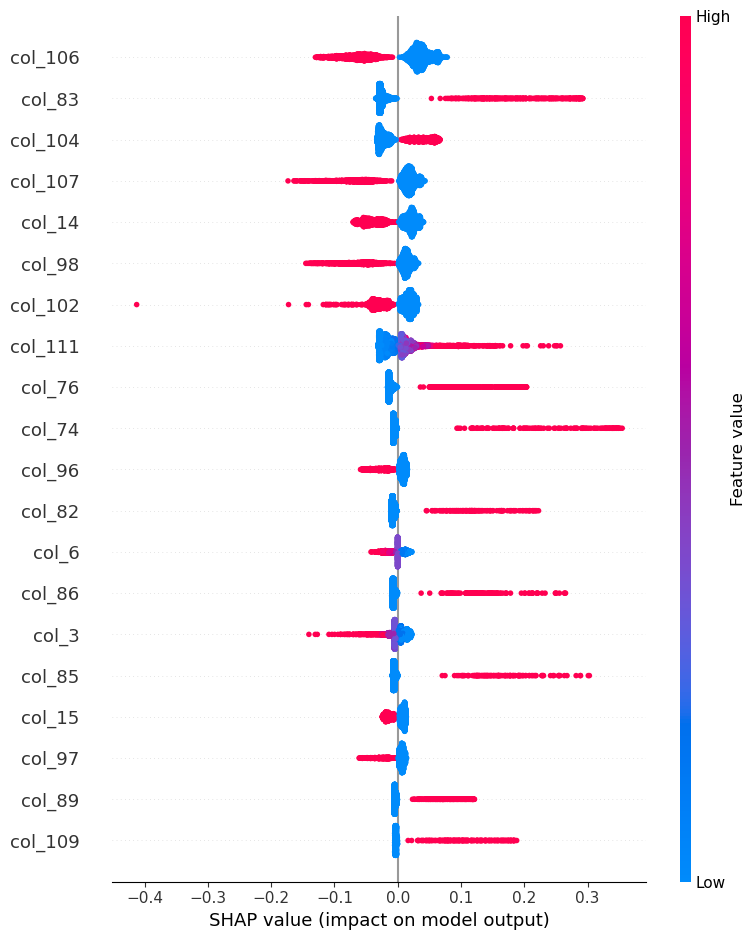

[[-1.09926442e-04 -1.63181599e-04  1.87932263e-03 ... -2.88149411e-03
  -1.21097484e-03 -9.53795197e-03]
 [ 2.72938685e-03 -5.22456856e-04  1.84214513e-02 ... -4.25154519e-03
  -1.83999555e-03  9.55410452e-02]
 [ 2.44397563e-05 -2.60287008e-04  2.35432227e-03 ... -4.24098028e-03
  -1.37788585e-03 -1.66653887e-02]
 ...
 [ 2.52433210e-03  9.12059458e-04  1.50647905e-02 ... -3.83261245e-03
  -1.68973925e-03 -2.46113776e-02]
 [ 2.30073500e-04  1.21186794e-03  7.37245876e-03 ... -3.86117105e-03
  -1.19827060e-03 -1.58406882e-02]
 [-4.22744043e-04 -2.51395528e-04 -4.34408453e-03 ... -3.70587415e-03
  -1.17716084e-03 -1.59953075e-02]]        col_1  col_2  col_3  col_4  col_5  col_6  col_13  col_14  col_15  \
15217    188      0      1      0      0      7       0       1       0   
8494      45      0      0      0      1     -1       0       1       0   
7280     176      0      1      0      1      8       0       0       1   
10245    161      2      0      0      0      2       0       1 

In [387]:
#shap.summary_plot
shap.summary_plot(shap_values, X_test)#, feature_names=feature_names_pca)
print(shap_values, X_test)

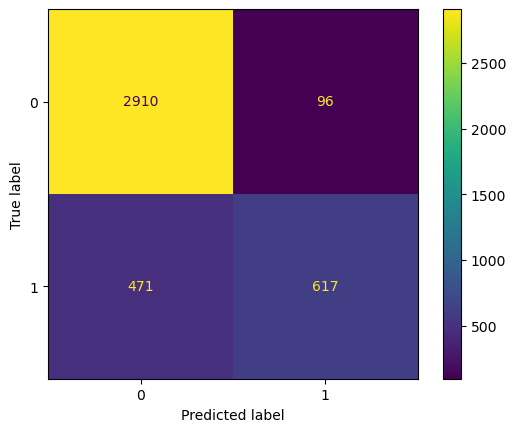

In [388]:
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [394]:
X = fraud_reduced[['col_106','col_83','col_104','col_107','col_14']]
print(X.shape)
y = fraud_reduced['targets']
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

(20468, 5)
(20468,)


In [395]:
# Define an objective function for Optuna
def objective(trial):
    # Create SMOTE, StandardScaler, and PCA instances with trial parameters
    #smote = SMOTE(random_state=1, k_neighbors=trial.suggest_int("k_neighbors", 3, 10))
    scaler = StandardScaler()
    pca = PCA(n_components=trial.suggest_int("pca_components", 1, X_train.shape[1]))

    # Create the pipeline with SMOTE, StandardScaler, PCA, and the classifier
    lr_pipeline = Pipeline([
        #("smote", smote),
        ("scaler", scaler),
        ("pca", pca),
        ("classifier", LogisticRegression(
            C=trial.suggest_loguniform("C", 1e-5, 1e5),
            solver= trial.suggest_categorical("solver", ["liblinear", "lbfgs"]),# "saga"]),
            max_iter= trial.suggest_int("max_iter", 500, 5000),
            random_state=1
        ))
    ])

    # Calculate ROC AUC score using cross-validation
    lr_roc_auc = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()

    # Return the negative ROC AUC score as Optuna minimizes the objective
    return -lr_roc_auc

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the hyperparameters
study.optimize(objective, n_trials=3)

# Get the best parameters from the study
best_params = study.best_trial.params

# Build the final pipeline with the best hyperparameters
final_pipeline = Pipeline([
    #("smote", SMOTE(random_state=1, k_neighbors=best_params["k_neighbors"])),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=best_params["pca_components"])),
    ("classifier", LogisticRegression(
        C=best_params["C"],
        solver=best_params['solver'],
        max_iter=best_params['max_iter'],
        random_state=1
    ))
])

# Train and evaluate the final pipeline
final_pipeline.fit(X_train, y_train)
X_test_pca = final_pipeline.named_steps['pca'].transform(final_pipeline.named_steps['scaler'].transform(X_test))

y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression ROC AUC on test set:", roc_auc_test)

[I 2023-12-07 18:48:10,095] A new study created in memory with name: no-name-835b387c-ca18-4924-a78f-4a6c508d2783
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-07 18:48:10,202] Trial 0 finished with value: -0.8169052328013542 and parameters: {'pca_components': 4, 'C': 1.1968415340600144e-05, 'solver': 'lbfgs', 'max_iter': 3411}. Best is trial 0 with value: -0.8169052328013542.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-12-07 18:48:10,343] Trial 1 finished with value: -0.8276848565929121 and parameters: {'pca_components': 5, 'C': 4352.960197236838, 'solver': 'liblinear', 'max_iter': 2888}. Best is trial 1 with value: -0.8276848565929121.
suggest_loguniform has been deprecated in v3.

Logistic Regression ROC AUC on test set: 0.8280812761731439


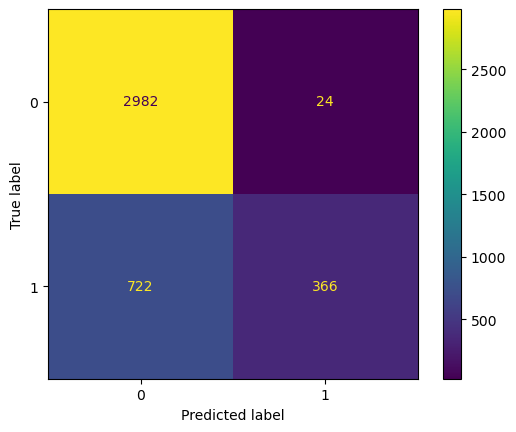

In [396]:
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()